In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw = """
3216 5.00 0.00
0 5.00 0.00
401 5.00 0.00
803 5.00 0.00
1205 5.00 0.00
1607 5.00 0.00
2010 5.00 0.00
2412 5.00 0.00
2813 5.00 0.00
3216 5.00 0.00
3618 4.99 0.01
4021 4.79 0.21
4422 4.60 0.40
4825 4.42 0.58
5227 4.25 0.75
5629 4.08 0.92
6031 3.92 1.08
6433 3.76 1.24
6836 3.62 1.38
7238 3.48 1.52
0 5.00 0.00
401 4.80 0.20
803 4.61 0.39
1205 4.43 0.57
1607 4.26 0.74
2010 4.09 0.91
2412 3.93 1.07
2813 3.77 1.23
3216 3.63 1.37
3618 3.48 1.52
4021 3.34 1.66
4423 3.21 1.79
4825 3.08 1.92
5227 2.97 2.03
5629 2.85 2.15
6032 2.74 2.26
6434 2.63 2.37
6836 2.52 2.48
7238 2.42 2.58
7641 2.33 2.67
8043 2.24 2.76
8445 2.15 2.85
8847 2.06 2.94
9249 1.98 3.02
9652 1.91 3.09
10054 1.83 3.17
10457 1.76 3.24
10859 1.69 3.31
11260 1.62 3.38
11663 1.56 3.44
12065 1.50 3.50
12468 1.44 3.56
12870 1.38 3.62
13273 1.32 3.68
13675 1.28 3.72
14077 1.22 3.78
14480 1.17 3.83
14882 1.13 3.87
15285 1.09 3.91
15686 1.04 3.96
16089 1.00 4.00
16491 0.96 4.04
""".strip()

In [3]:
rows = []
for line in raw.splitlines():
    parts = line.split()
    if len(parts) != 3:
        continue
    t_ms, v_r, v_c = parts
    rows.append((int(t_ms), float(v_r), float(v_c)))

df = pd.DataFrame(rows, columns=["t_ms", "V_R", "V_C"])

t_adj = []
offset = 0
prev = None
for t in df["t_ms"].values:
    if prev is not None and t < prev:
        offset += prev
    t_adj.append(t + offset)
    prev = t
df["t_ms_unwrapped"] = t_adj
df["t_s"] = df["t_ms_unwrapped"] / 1000.0

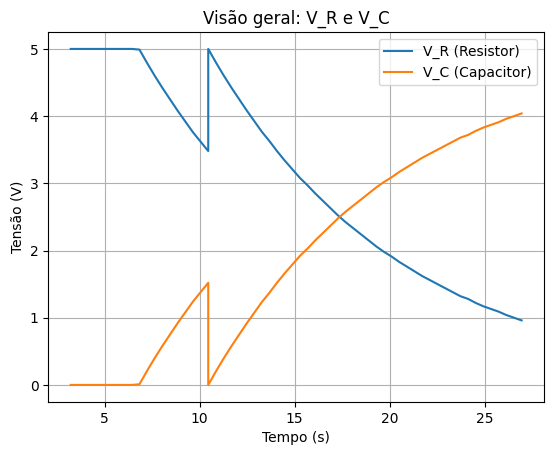

In [4]:
plt.figure()
plt.plot(df["t_s"], df["V_R"], label="V_R (Resistor)")
plt.plot(df["t_s"], df["V_C"], label="V_C (Capacitor)")
plt.xlabel("Tempo (s)")
plt.ylabel("Tensão (V)")
plt.title("Visão geral: V_R e V_C")
plt.legend()
plt.grid(True)
plt.savefig("assets/visao_geral_vr_vc.png", dpi=150, bbox_inches="tight")
plt.show()

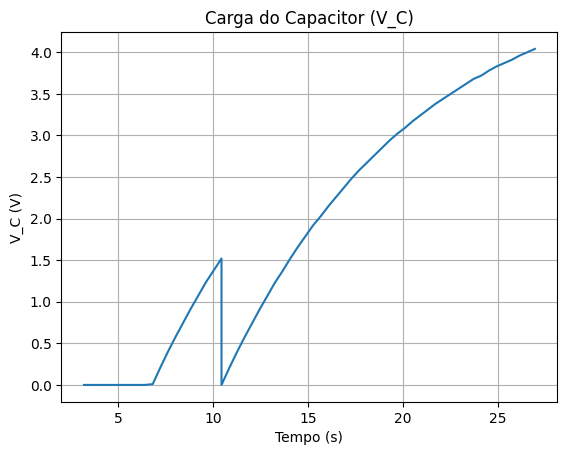

In [5]:

# 4.2 Carga do capacitor (V_C)
plt.figure()
plt.plot(df["t_s"], df["V_C"])
plt.xlabel("Tempo (s)")
plt.ylabel("V_C (V)")
plt.title("Carga do Capacitor (V_C)")
plt.grid(True)
plt.savefig("assets/carga_capacitor.png", dpi=150, bbox_inches="tight")
plt.show()

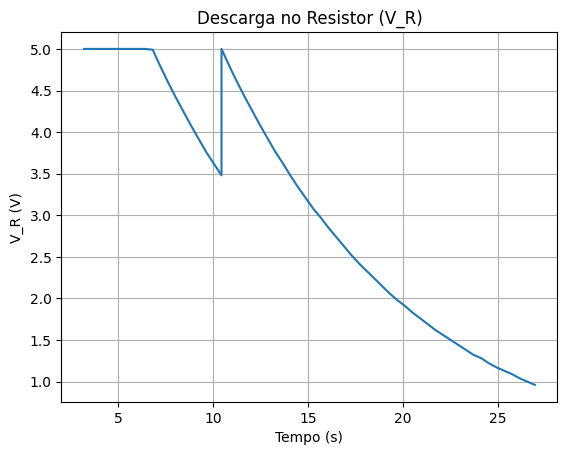

In [6]:
# 4.3 Descarga no resistor (V_R)
plt.figure()
plt.plot(df["t_s"], df["V_R"])
plt.xlabel("Tempo (s)")
plt.ylabel("V_R (V)")
plt.title("Descarga no Resistor (V_R)")
plt.grid(True)
plt.savefig("assets/descarga_resistor.png", dpi=150, bbox_inches="tight")
plt.show()

tau estimado (a partir de V_R) ≈ 12.089 s


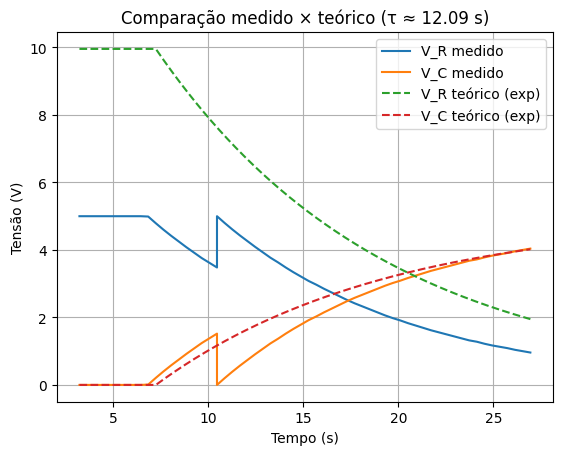

In [7]:
 # Estimar tau e comparar com o modelo teórico
# Pegamos trecho de decaimento
mask_decay = (df["V_R"] < 4.98) & (df["V_R"] > 1.0)
df_decay = df.loc[mask_decay, ["t_s", "V_R"]].copy()

tau = None
v0 = None
if len(df_decay) >= 3:
    # ln(V_R) = ln(V0) - t/tau  -> regressão linear
    x = df_decay["t_s"].values
    y = np.log(df_decay["V_R"].values)
    A = np.vstack([np.ones_like(x), x]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    if b != 0:
        tau = -1.0 / b
        v0 = math.exp(a)

print(f"tau estimado (a partir de V_R) ≈ {tau:.3f} s" if tau else "Não foi possível estimar tau.")

# Curvas teóricas (alinhadas ao início do decaimento)
if tau:
    t0 = df_decay["t_s"].min()
    t_theory = np.linspace(df["t_s"].min(), df["t_s"].max(), 400)
    V_f = 5.0

    # V_R_teor(t) = V0 * exp(-(t - t0)/tau), com “trava” antes de t0
    V_R_teor = v0 * np.exp(-(t_theory - t0) / tau)
    V_R_teor[t_theory < t0] = v0

    # V_C_teor(t) = V_f * (1 - exp(-(t - t0)/tau)), 0 antes de t0
    V_C_teor = V_f * (1 - np.exp(-(t_theory - t0) / tau))
    V_C_teor[t_theory < t0] = 0.0

    plt.figure()
    plt.plot(df["t_s"], df["V_R"], label="V_R medido")
    plt.plot(df["t_s"], df["V_C"], label="V_C medido")
    plt.plot(t_theory, V_R_teor, "--", label="V_R teórico (exp)")
    plt.plot(t_theory, V_C_teor, "--", label="V_C teórico (exp)")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Tensão (V)")
    plt.title(f"Comparação medido × teórico (τ ≈ {tau:.2f} s)")
    plt.legend()
    plt.grid(True)
    plt.savefig("assets/comparacao_teorico_medido.png", dpi=150, bbox_inches="tight")
    plt.show()